In [1]:
import os

import numpy as np
import matplotlib.pyplot as plt

import pandas as pd
import geopandas as gpd

import xarray as xr

from shapely.wkt import loads
from shapely.geometry import Polygon
from shapely.geometry import Point

import rasterio
import rasterio.sample

from functools import partial
from scipy.spatial.distance import cdist

In [2]:
parquet_files = {'marine_protected_areas': ('../data/PR100/Habitat/marine_protected_areas.parquet',
  'EPSG:32161',
  'centroid'),
 'land_nationwide_hapc': ('../data/PR100/Habitat/land_nationwide_hapc.parquet',
  'EPSG:32161',
  'centroid'),
 'artificial_reefs': ('../data/PR100/Habitat/artificial_reefs.parquet',
  'EPSG:32161',
  'irrelevant'),
 'nationwide_hapc': ('../data/PR100/Habitat/nationwide_hapc.parquet',
  'EPSG:32161',
  'irrelevant'),
 'areas_protegidas_agencia': ('../data/PR100/Habitat/areas_protegidas_agencia.parquet',
  'EPSG:32161',
  'centroid'),
 'noaa_charted_submarine_cables_30m_buffer': ('../data/PR100/Infrastructure/noaa_charted_submarine_cables_30m_buffer.parquet',
  'EPSG:32161',
  'irrelevant'),
 'setbacks_xmission': ('../data/PR100/Infrastructure/setbacks_xmission.parquet',
  'EPSG:32161',
  'lines'),
 'submarine_cable_30m_buffer': ('../data/PR100/Infrastructure/submarine_cable_30m_buffer.parquet',
  'EPSG:32161',
  'irrelevant'),
 'pipeline_areas': ('../data/PR100/Infrastructure/pipeline_areas.parquet',
  'EPSG:32161',
  'irrelevant'),
 'setbacks_roads': ('../data/PR100/Infrastructure/setbacks_roads.parquet',
  'EPSG:4326',
  'density'),
 'setbacks_runway': ('../data/PR100/Infrastructure/setbacks_runway.parquet',
  'EPSG:4326',
  'centroid'),
 'setbacks_airport': ('../data/PR100/Infrastructure/setbacks_airport.parquet',
  'EPSG:4326',
  'points'),
 'setbacks_buildings': ('../data/PR100/Infrastructure/setbacks_buildings.parquet',
  'EPSG:4326',
  'density'),
 'federal_and_state_waters': ('../data/PR100/Boundaries/federal_and_state_waters.parquet',
  'EPSG:32161',
  'centroid'),
 'coastal_zone_mgmt_act_boundary': ('../data/PR100/Boundaries/coastal_zone_mgmt_act_boundary.parquet',
  'EPSG:32161',
  'centroid'),
 'land_protected_areas': ('../data/PR100/Boundaries/land_protected_areas.parquet',
  'EPSG:32161',
  'centroid'),
 'water_bodies': ('../data/PR100/Topography/water_bodies.parquet',
  'EPSG:4326',
  'centroid'),
 'wrecks_and_obstructions': ('../data/PR100/Hazards/wrecks_and_obstructions.parquet',
  'EPSG:4326',
  'points'),
 'ocean_disposal_sites': ('../data/PR100/Hazards/ocean_disposal_sites.parquet',
  'EPSG:32161',
  'centroid'),
 'tropical_cyclone_storm_segments': ('../data/PR100/Hazards/tropical_cyclone_storm_segments.parquet',
  'EPSG:32161',
  'lines'),
 'tropical_cyclone_wind_exposure': ('../data/PR100/Hazards/tropical_cyclone_wind_exposure.parquet',
  'EPSG:32161',
  'wind_exposure'),
 'unexploded_ordinance_areas_fuds': ('../data/PR100/Hazards/unexploded_ordinance_areas_fuds.parquet',
  'EPSG:32161',
  'irrelevant'),
 'danger_zones_and_restricted_areas': ('../data/PR100/Hazards/danger_zones_and_restricted_areas.parquet',
  'EPSG:32161',
  'centroid'),
 'unexploded_ordinance_areas': ('../data/PR100/Hazards/unexploded_ordinance_areas.parquet',
  'EPSG:4326',
  'centroid')}

In [3]:
tif_files = ['../data/wind_atlas/PRI_power-density_50m.tif',
 '../data/wind_atlas/PRI_power-density_100m.tif',
 '../data/wind_atlas/PRI_power-density_150m.tif',
 '../data/wind_atlas/PRI_power-density_200m.tif',
 '../data/wind_atlas/PRI_power-density_10m.tif',
 '../data/wind_atlas/PRI_wind-speed_100m.tif',
 '../data/solar_atlas/Yearly_PVOUT.tif',
 '../data/solar_atlas/Daily_PVOUT.tif',
 '../data/PR100/Topography/slope.tif',
 '../data/PR100/Topography/elevation.tif']

In [4]:
binary_mask_columns = ['marine_protected_areas', 'land_nationwide_hapc',
       'areas_protegidas_agencia', 'setbacks_xmission',
       'setbacks_runway', 'setbacks_airport',
       'federal_and_state_waters', 'coastal_zone_mgmt_act_boundary',
       'land_protected_areas', 'water_bodies', 'wrecks_and_obstructions',
       'ocean_disposal_sites', 'danger_zones_and_restricted_areas',
       'unexploded_ordinance_areas']

In [5]:
def find_parquet_files(directory):
    """
    Find all Parquet files within a directory and its subdirectories.

    :param directory: The base directory to search.
    :return: A list of paths to Parquet files.

    Note: This function isn't used in this notebook, because the file list
    has already been generated and enriched (see 'parquet_files' dict above)
    """
    parquet_files = []
    for root, dirs, files in os.walk(directory):
        for file in files:
            if file.endswith('.parquet'):
                parquet_files.append(os.path.join(root, file))
    return parquet_files

In [6]:
def find_tif_files(directory):
    """
    Find all TIF files within a directory and its subdirectories.

    :param directory: The base directory to search.
    :return: A list of paths to TIF files.

    Note: This function isn't used in this notebook, because the file list
    has already been generated (see 'tif_files' dict above)
    """
    tif_files = []
    for root, dirs, files in os.walk(directory):
        for file in files:
            if file.endswith('.tif'):
                tif_files.append(os.path.join(root, file))
    return tif_files

In [7]:
def get_gdf(parquet_file, crs, grid):
    df = pd.read_parquet(parquet_file)
    df['geometry'] = df['geometry'].apply(loads)
    gdf = gpd.GeoDataFrame(df, geometry='geometry')
    gdf.set_crs(crs, inplace=True)
    gdf.to_crs(grid.crs, inplace=True)
    return gdf

In [8]:
def create_grid(x_start, x_end, y_start, y_end, square_size):
    grid = []
    for x in np.arange(x_start, x_end, square_size):
        for y in np.arange(y_start, y_end, square_size):
            # Define the square's coordinates
            square = Polygon([(x, y), (x + square_size, y), (x + square_size, y + square_size), (x, y + square_size)])
            grid.append(square)
    return gpd.GeoDataFrame({'geometry': grid}, crs="EPSG:32161")

In [9]:
def calculate_cyclone_failure_percentage(df):
    probability_of_hurricane_occuring = df['occurrence64ktMajorHurricanes'] / 117
    probability_of_failure_due_to_hurricane = 0.5
    average_life_span = 25
    df['turbine_cyclone_failure_percentage'] = probability_of_hurricane_occuring * probability_of_failure_due_to_hurricane * average_life_span / 2
    return df

In [10]:
def rasterize_cyclone_failure_risk(grid_gdf, cyclone_data_gdf):
    # Ensure both dataframes are in the same CRS
    cyclone_data_gdf = cyclone_data_gdf.to_crs(grid_gdf.crs)

    # Spatial join - to associate cyclone data with each grid cell
    joined_gdf = gpd.sjoin(grid_gdf, cyclone_data_gdf, how='left', predicate='intersects')

    # Apply the failure cost calculation to each row
    joined_gdf = calculate_cyclone_failure_percentage(joined_gdf)

    # Group by grid cell index and average the scores within each cell
    aggregated_scores = joined_gdf.groupby(joined_gdf.index)['turbine_cyclone_failure_percentage'].mean()

    return aggregated_scores.reindex(grid_gdf.index, fill_value=0)

In [11]:
def rasterize(grid, data, type):
    joined_gdf = gpd.sjoin(grid, data[['geometry']], how='right', predicate='intersects')
    count = joined_gdf.groupby('index_left').size().reindex(grid.index, fill_value=0)
    if type == 'density':
        return count
    else:
        return count > 0

In [12]:
def process_parquet_file(file_path, crs, type, handle, grid):
    gdf = get_gdf(file_path, crs, grid)
    if type == 'irrelevant':
        pass
    elif type == 'wind_exposure':
        grid[handle] = rasterize_cyclone_failure_risk(grid, gdf)
    else:
        grid[handle] = rasterize(grid, gdf, type)

In [13]:
def process_parquet_files(files, grid):
    for handle, file_data in files.items():
        file_path = file_data[0]
        crs = file_data[1]
        type = file_data[2]
        print(f'Processing file: {file_path}')
        process_parquet_file(file_path, crs, type, handle, grid)

In [14]:
def process_tif_file(file_path, grid, coords):
    handle = file_path.split('/')[-1].split('.')[0]
    # Open the raster and sample values at each coordinate
    with rasterio.open(file_path) as src:
        if grid.crs != src.crs:
            centroids = grid.geometry.centroid.to_crs(src.crs)
            coords = [(x,y) for x, y in zip(centroids.geometry.x, centroids.geometry.y)]

        # Sample the raster at each centroid location
        values = [x[0] for x in rasterio.sample.sample_gen(src, coords)]
    
    # Assign the values to the grid dataframe
    grid[handle] = values

In [15]:
def process_hourly_file(grid, hourly):
    # Ensure both DataFrames are in the same CRS
    if grid.crs != hourly.crs:
        hourly_wind = hourly.to_crs(grid.crs)

    # Iterate over the columns in hourly and assign values to grid
    for column in hourly.columns:
        joined = gpd.sjoin_nearest(grid, hourly[[column, 'geometry']], how='left')
        grid[column] = joined[column]

    return grid

In [16]:
def process_tif_files(files, grid):
    # Compute centroids
    centroids = grid.geometry.centroid
    # Create an array of coordinates in (x, y) format
    coords = [(x,y) for x, y in zip(centroids.geometry.x, centroids.geometry.y)]

    for file_path in tif_files:
        print(f'Processing file: {file_path}')
        process_tif_file(file_path, grid, coords)

In [17]:
def create_final_binary_mask(grid, binary_mask_columns):
    """
    Create a final binary mask column in the grid dataframe, which is True if any of 
    the specified binary mask columns are True.

    :param grid: DataFrame containing the grid information.
    :param binary_mask_columns: List of columns to be considered for the binary mask.
    :return: Updated DataFrame with an additional 'final_binary_mask' column.
    """

    # Check if any of the specified columns are True for each row
    grid['masked'] = grid[binary_mask_columns].any(axis=1)

In [43]:
def plot_columns(gdf):
    for column in gdf.columns:
        if column in ['geometry', 'centroid']:
            continue
        fig, ax = plt.subplots(1, 1, figsize=(12, 8))
        environment_gdf.plot(column=column, ax=ax, legend=True)
        plt.title(column)
        plt.show()

In [19]:
environment_gdf = create_grid(100000, 300000, 200000, 300000, 500)

In [20]:
process_parquet_files(parquet_files, environment_gdf)

Processing file: ../data/PR100/Habitat/marine_protected_areas.parquet
Processing file: ../data/PR100/Habitat/land_nationwide_hapc.parquet
Processing file: ../data/PR100/Habitat/artificial_reefs.parquet
Processing file: ../data/PR100/Habitat/nationwide_hapc.parquet
Processing file: ../data/PR100/Habitat/areas_protegidas_agencia.parquet
Processing file: ../data/PR100/Infrastructure/noaa_charted_submarine_cables_30m_buffer.parquet
Processing file: ../data/PR100/Infrastructure/setbacks_xmission.parquet
Processing file: ../data/PR100/Infrastructure/submarine_cable_30m_buffer.parquet
Processing file: ../data/PR100/Infrastructure/pipeline_areas.parquet
Processing file: ../data/PR100/Infrastructure/setbacks_roads.parquet
Processing file: ../data/PR100/Infrastructure/setbacks_runway.parquet
Processing file: ../data/PR100/Infrastructure/setbacks_airport.parquet
Processing file: ../data/PR100/Infrastructure/setbacks_buildings.parquet
Processing file: ../data/PR100/Boundaries/federal_and_state_wat

In [21]:
process_tif_files(tif_files, environment_gdf)

Processing file: ../data/wind_atlas/PRI_power-density_50m.tif
Processing file: ../data/wind_atlas/PRI_power-density_100m.tif
Processing file: ../data/wind_atlas/PRI_power-density_150m.tif
Processing file: ../data/wind_atlas/PRI_power-density_200m.tif
Processing file: ../data/wind_atlas/PRI_power-density_10m.tif
Processing file: ../data/wind_atlas/PRI_wind-speed_100m.tif
Processing file: ../data/solar_atlas/Yearly_PVOUT.tif
Processing file: ../data/solar_atlas/Daily_PVOUT.tif
Processing file: ../data/PR100/Topography/slope.tif
Processing file: ../data/PR100/Topography/elevation.tif


In [22]:
create_final_binary_mask(environment_gdf, binary_mask_columns)

In [23]:
environment_gdf['centroid'] = environment_gdf.centroid

In [24]:
environment_gdf['occupied'] = False

## Calculating per-cell energy demand

In [25]:
total_building_density = environment_gdf['setbacks_buildings'].sum()

total_power_density = 100000 # TODO -- Get total power demand for PR

total_power_density_per_building_density = total_power_density / total_building_density

environment_gdf['demand'] = environment_gdf['setbacks_buildings'] * total_power_density_per_building_density

## Calculating dist to nearest transmission line

In [26]:
def nearest_transmission_distance(row, gdf):
    if row['setbacks_xmission'] or row['masked']:
        return 0
    else:
        # Calculate distances to all cells where setbacks_xmission is True
        distances = gdf[gdf['setbacks_xmission']]['geometry'].distance(row['geometry'])
        # Return the minimum distance
        return distances.min()

In [27]:
environment_gdf['distance_to_transmission_line'] = environment_gdf.apply(nearest_transmission_distance, gdf=environment_gdf, axis=1)

# Incorporating ERA5 Wind Speed Data

In [28]:
ds = xr.open_dataset("../data/generation_and_demand/2019_wind_speeds.nc")
ds

<xarray.Dataset>
Dimensions:           (hour: 24, latitude: 7, longitude: 21)
Coordinates:
  * hour              (hour) int32 0 1 2 3 4 5 6 7 8 ... 16 17 18 19 20 21 22 23
  * longitude         (longitude) float64 -68.0 -67.75 -67.5 ... -63.25 297.0
  * latitude          (latitude) float64 18.9 18.65 18.4 18.15 17.9 17.65 17.4
    number            int32 ...
    step              timedelta64[ns] ...
    surface           float64 ...
Data variables:
    u100              (hour, latitude, longitude) float32 ...
    v100              (hour, latitude, longitude) float32 ...
    total_wind_speed  (hour, latitude, longitude) float32 ...
Attributes:
    GRIB_edition:            1
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts

In [29]:
total_wind_speed_array = ds.total_wind_speed
total_wind_speed_np = np.array(total_wind_speed_array)

print(total_wind_speed_np.shape)

total_wind_speed_array

(24, 7, 21)


<xarray.DataArray 'total_wind_speed' (hour: 24, latitude: 7, longitude: 21)>
array([[[6.883811, 7.046881, ..., 7.032288, 7.033096],
        [6.374979, 6.388773, ..., 7.045452, 7.047324],
        ...,
        [6.828828, 6.893982, ..., 7.204221, 7.21257 ],
        [7.260835, 7.340557, ..., 7.271497, 7.305086]],

       [[7.149816, 7.29084 , ..., 7.27289 , 7.283437],
        [6.64298 , 6.633455, ..., 7.311168, 7.323074],
        ...,
        [7.134621, 7.171606, ..., 7.541332, 7.541587],
        [7.574303, 7.636171, ..., 7.614145, 7.641643]],

       ...,

       [[6.147696, 6.369555, ..., 6.591186, 6.583451],
        [5.733232, 5.767823, ..., 6.568635, 6.561281],
        ...,
        [6.313016, 6.444892, ..., 6.612079, 6.581641],
        [6.73274 , 6.865387, ..., 6.655438, 6.64425 ]],

       [[6.525208, 6.703221, ..., 6.790899, 6.779109],
        [6.039401, 6.044993, ..., 6.780481, 6.779428],
        ...,
        [6.549355, 6.617996, ..., 6.879613, 6.865842],
        [6.986192, 7.075145, ..., 6.945799, 6.949914]]], dtype=float32)
Coordinates:
  * hour       (hour) int32 0 1 2 3 4 5 6 7 8 9 ... 15 16 17 18 19 20 21 22 23
  * longitude  (longitude) float64 -68.0 -67.75 -67.5 ... -63.5 -63.25 297.0
  * latitude   (latitude) float64 18.9 18.65 18.4 18.15 17.9 17.65 17.4
    number     int32 ...
    step       timedelta64[ns] ...
    surface    float64 ...

In [30]:
hrs = np.array(ds.coords['hour'])
lats = np.array(ds.coords['latitude'])
lons = np.array(ds.coords['longitude'])

lists = []
for lat_idx in range(0, ds.coords['latitude'].shape[0]):
    for lon_idx in range(0, ds.coords['longitude'].shape[0]):
        hour_wind_speeds = {}
    
        this_point_wind_speeds = total_wind_speed_np[:, lat_idx, lon_idx]
        this_normalized_wind_speeds = this_point_wind_speeds/np.mean(this_point_wind_speeds)
        
        for hr_idx in range(0, ds.coords['hour'].shape[0]):
            this_point = Point(lats[lat_idx], lons[lon_idx])
    
            this_hour = hrs[hr_idx]

            hour_wind_speeds[f'normalized_wind_speed_hour_{this_hour}'] = this_normalized_wind_speeds[hr_idx]
            hour_wind_speeds[f'wind_speed_hour_{this_hour}'] = this_point_wind_speeds[hr_idx]
        

        lists.append({'latitude': lats[lat_idx], 'longitude': lons[lon_idx],'geometry': this_point, **hour_wind_speeds})

diurnal_wind_speeds = gpd.GeoDataFrame(lists)
diurnal_wind_speeds

,latitude,longitude,geometry,normalized_wind_speed_hour_0,wind_speed_hour_0,normalized_wind_speed_hour_1,wind_speed_hour_1,normalized_wind_speed_hour_2,wind_speed_hour_2,normalized_wind_speed_hour_3,...,normalized_wind_speed_hour_19,wind_speed_hour_19,normalized_wind_speed_hour_20,wind_speed_hour_20,normalized_wind_speed_hour_21,wind_speed_hour_21,normalized_wind_speed_hour_22,wind_speed_hour_22,normalized_wind_speed_hour_23,wind_speed_hour_23
0,18.9,-68.00,POINT (18.900 -68.000),1.060519,6.883811,1.101500,7.149816,1.123059,7.289755,1.129996,...,0.869083,5.641197,0.904465,5.870867,0.963585,6.254614,0.947114,6.147696,1.005273,6.525208
1,18.9,-67.75,POINT (18.900 -67.750),1.068448,7.046881,1.105437,7.290840,1.122644,7.404329,1.125172,...,0.883517,5.827178,0.924930,6.100317,0.981059,6.470517,0.965752,6.369555,1.016342,6.703221
2,18.9,-67.50,POINT (18.900 -67.500),1.073437,7.281335,1.101815,7.473827,1.113866,7.555570,1.110015,...,0.919174,6.234938,0.960884,6.517866,1.008753,6.842569,0.992890,6.734965,1.030925,6.992966
3,18.9,-67.25,POINT (18.900 -67.250),1.075938,7.448746,1.092630,7.564304,1.095429,7.583685,1.086838,...,0.965346,6.683114,1.002519,6.940462,1.041842,7.212699,1.019677,7.059250,1.048190,7.256645
4,18.9,-67.00,POINT (18.900 -67.000),1.065876,7.552485,1.069280,7.576605,1.067024,7.560621,1.058422,...,1.022356,7.244117,1.047134,7.419686,1.073606,7.607257,1.039389,7.364804,1.057290,7.491646
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
142,17.4,-64.00,POINT (17.400 -64.000),0.972303,7.256151,1.014509,7.571131,1.044914,7.798039,1.064020,...,0.912362,6.808823,0.916494,6.839661,0.938790,7.006053,0.904009,6.746482,0.935454,6.981157
143,17.4,-63.75,POINT (17.400 -63.750),0.974427,7.261871,1.018561,7.590777,1.048689,7.815305,1.069754,...,0.906955,6.759041,0.912192,6.798064,0.936903,6.982224,0.901333,6.717142,0.935353,6.970671
144,17.4,-63.50,POINT (17.400 -63.500),0.977007,7.269920,1.022165,7.605941,1.052690,7.833073,1.075465,...,0.902618,6.716385,0.909693,6.769032,0.936835,6.970997,0.899677,6.694505,0.936179,6.966116
145,17.4,-63.25,POINT (17.400 -63.250),0.979378,7.271497,1.025529,7.614145,1.056805,7.846360,1.079935,...,0.899395,6.677655,0.909451,6.752314,0.937869,6.963305,0.896403,6.655438,0.935511,6.945799


### Kevin

Hey, so I need to do something here. I know how to do this in geopandas, but I think our `environment_gdf` has points defined in a non lat-lon reference system? So I'm not totally sure how to do this. 

Basically I want to merge the columns beginning with `normalized_wind_speed_hour_` in the `diurnal_wind_speeds` dataframe above onto our `environment_gdf`. Then, I can multiple each of these columns by `PRI_wind-speed_100m` as seen below. This will give us the diurnal mean wind speed values (using the wind speed curves from ERA5 but the mean wind speed values from Global Wind Atlas TIFs). 

Finally, I'll apply `power_curve_function` as seen below to get actual power values. 

Does this make sense? Is this something you could help with? 

In [31]:
environment_gdf['PRI_wind-speed_100m']

0        6.797408
1        6.796535
2        6.793331
3        6.787962
4        6.760642
           ...   
79995    7.470809
79996    7.470886
79997    7.470604
79998    7.470532
79999    7.470392
Name: PRI_wind-speed_100m, Length: 80000, dtype: float32

In [32]:
power_curve = {
    3: 25,
    3.5: 89, 
    4: 171, 
    4.5: 269, 
    5: 389,
    5.5: 533,
    6: 704,
    6.5: 906,
    7: 1136,
    7.5: 1400,
    8: 1674,
    8.5: 1934,
    9: 2160,
    9.5: 2316,
    10: 2416, 
    10.5: 2477,
    11: 2514,
    12: 2530, 
    12.5: 2530, 
    25: 2530,
}

power_curve_key = np.array(list(power_curve.keys()))
power_curve_val = np.array(list(power_curve.values()))

power_curve_function = partial(np.interp, xp=power_curve_key, fp=power_curve_val, left=0, right=0)

power_curve_function(3.8)

138.2

In [33]:
raw_wind_speed_cols = [col for col in diurnal_wind_speeds.columns.values if col[0:11] == 'wind_speed_']
power_cols = [col.replace('wind_speed', 'power_kw') for col in raw_wind_speed_cols]

diurnal_wind_speeds[power_cols] = diurnal_wind_speeds[raw_wind_speed_cols].map(power_curve_function)

<Axes: >

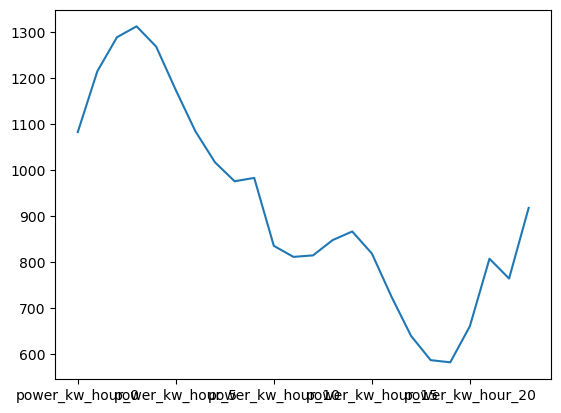

In [34]:
diurnal_wind_speeds.iloc[0][power_cols].plot()

In [35]:
environment_gdf.to_parquet('../data/processed/environment_gdf.parquet')

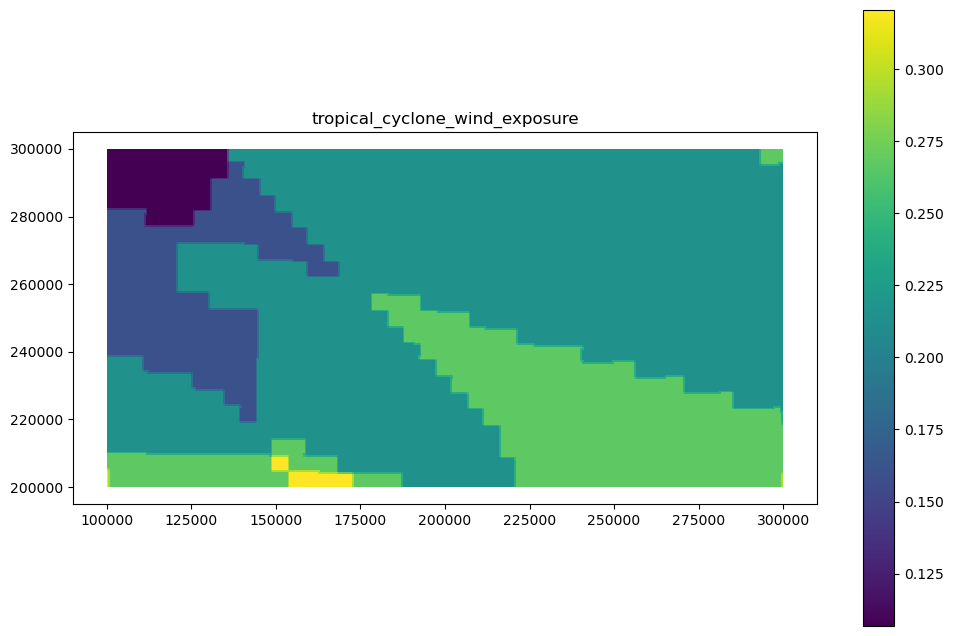

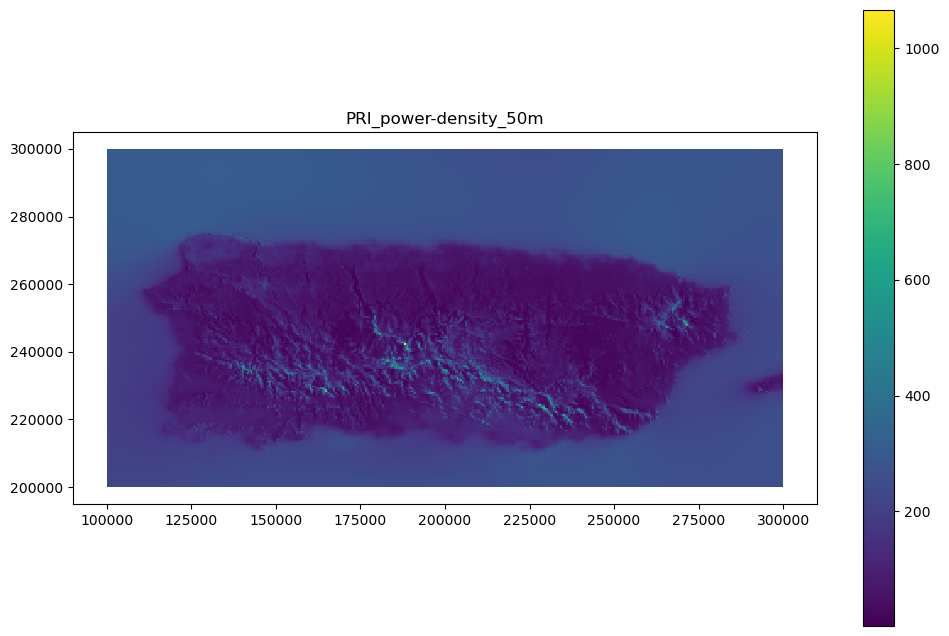

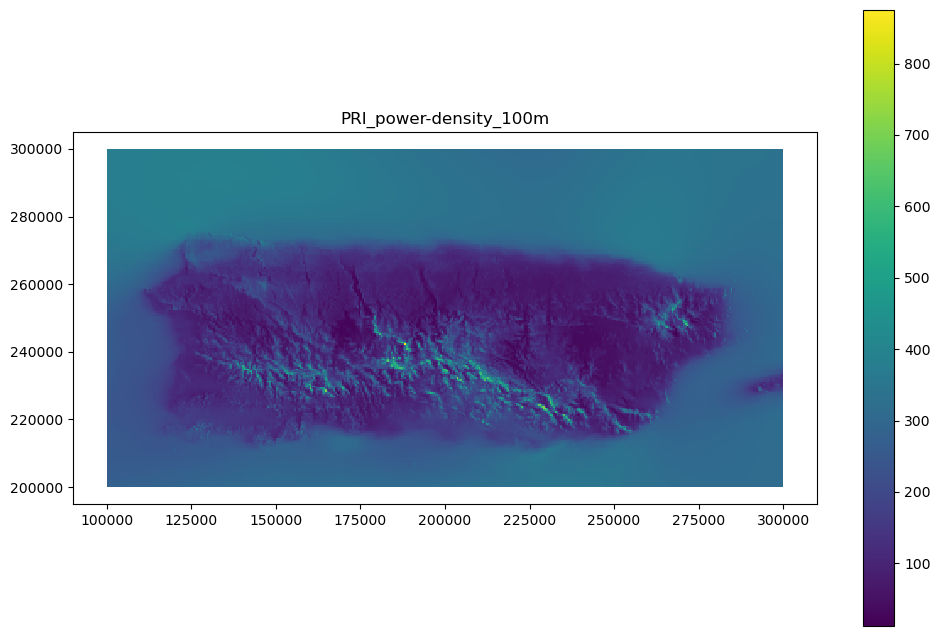

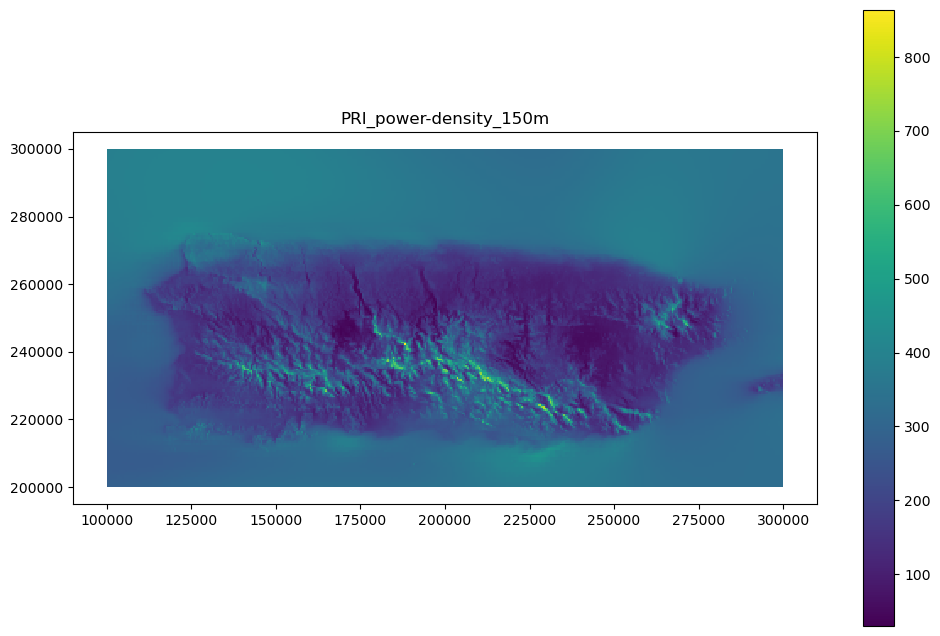

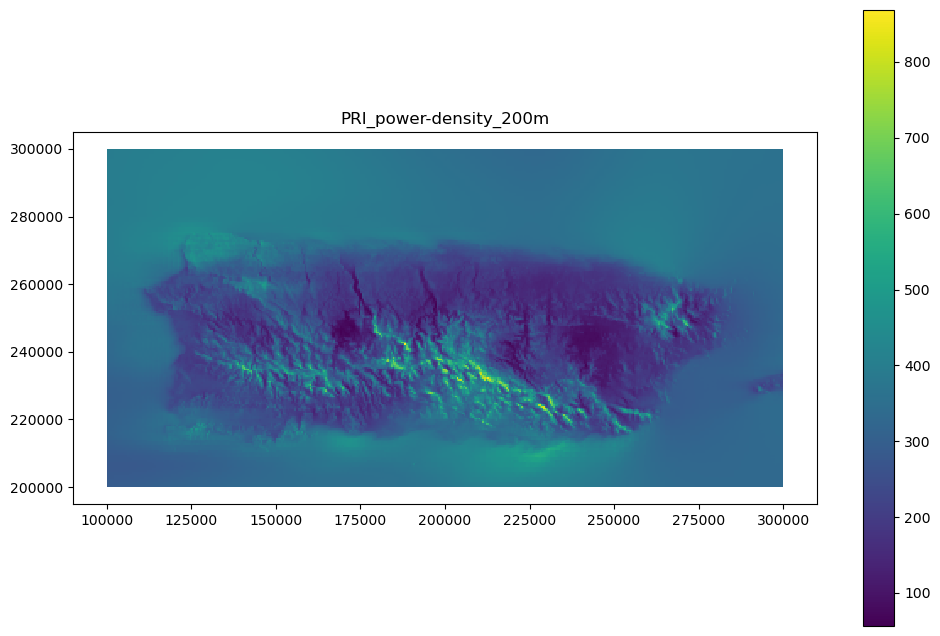

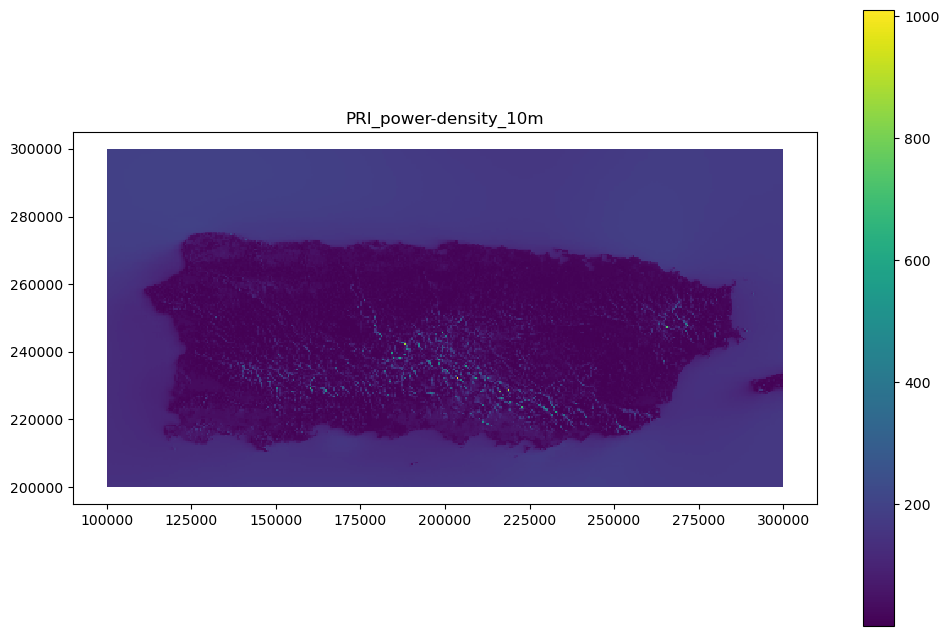

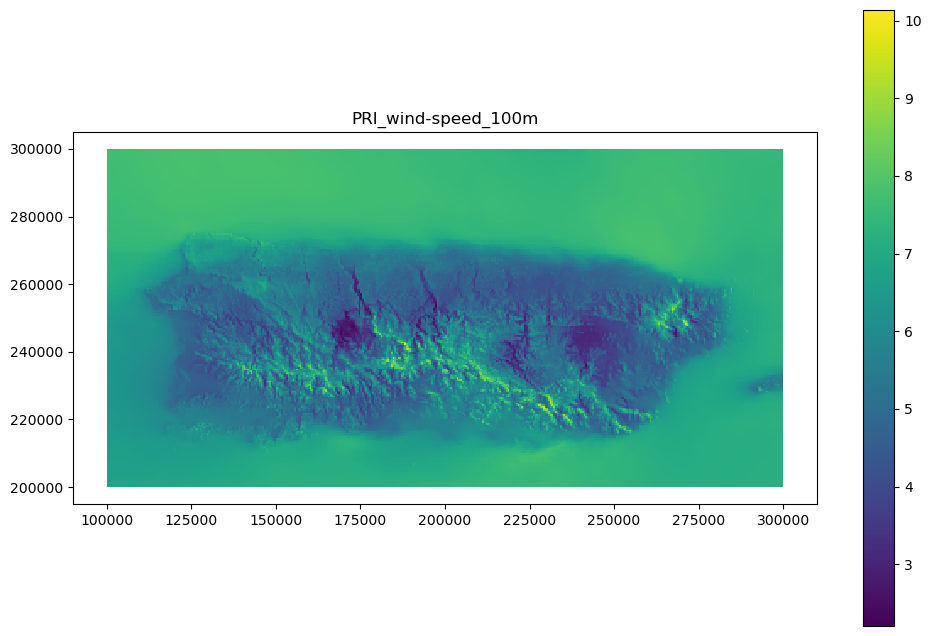

In [36]:
plot_columns(environment_gdf)

# Calculating Power Output

In [41]:
# def calculate_daily_power_output(environment_gdf):
#     solar_columns = [[f'solar_power_{i}' for i in range(1, 25)]]
#     wind_columns = [[f'solar_power_{i}' for i in range(1, 25)]]
#     environment_gdf['daily_solar_output'] = solar_columns.sum(axis=1)
#     environment_gdf['daily_wind_output'] = wind_columns.sum(axis=1)

In [40]:
# def calculate_power_output_reward(environment_gdf, demand):
#     """Uses supply and demand curve to determine the amount of demand satisfied by
#     the solar and wind installations"""
#     cost_kWh = 9999  # TODO

#     # Filter for solar and wind installations
#     solar_gdf = environment_gdf[(environment_gdf['occupied']) & (environment_gdf['installation'] == 'solar')]
#     wind_gdf = environment_gdf[(environment_gdf['occupied']) & (environment_gdf['installation'] == 'wind')]

#     # Prepare column names for solar and wind power
#     solar_power_columns = [f'solar_power_{i}' for i in range(1, 25)]
#     wind_power_columns = [f'wind_power_{i}' for i in range(1, 25)]

#     # Vectorized sum of power output for solar and wind for each hour
#     total_solar_power = solar_gdf[solar_power_columns].sum()
#     total_wind_power = wind_gdf[wind_power_columns].sum()

#     # Calculate the reward using vectorized minimum
#     total_power = total_solar_power + total_wind_power
#     reward = np.minimum(total_power, demand[1:]).sum() * cost_kWh

#     return reward

# Calculating Installation Costs

In [42]:
# def calculate_installation_cost(gdf):
#     solar_install_cost_per_cell = 9999 #TODO
#     wind_install_cost_per_cell = 9999 #TODO

#     solar_cost = gdf[gdf.installation == 'solar'] * 1.05 * solar_install_cost_per_cell
#     wind_cost = gdf[gdf.installation == 'wind'] * 1.05 * wind_install_cost_per_cell

In [44]:
environment_gdf.T

,0,1,2,3,4,5,6,7,8,9,...,79990,79991,79992,79993,79994,79995,79996,79997,79998,79999
geometry,"POLYGON ((100000 200000, 100500 200000, 100500...","POLYGON ((100000 200500, 100500 200500, 100500...","POLYGON ((100000 201000, 100500 201000, 100500...","POLYGON ((100000 201500, 100500 201500, 100500...","POLYGON ((100000 202000, 100500 202000, 100500...","POLYGON ((100000 202500, 100500 202500, 100500...","POLYGON ((100000 203000, 100500 203000, 100500...","POLYGON ((100000 203500, 100500 203500, 100500...","POLYGON ((100000 204000, 100500 204000, 100500...","POLYGON ((100000 204500, 100500 204500, 100500...",...,"POLYGON ((299500 295000, 300000 295000, 300000...","POLYGON ((299500 295500, 300000 295500, 300000...","POLYGON ((299500 296000, 300000 296000, 300000...","POLYGON ((299500 296500, 300000 296500, 300000...","POLYGON ((299500 297000, 300000 297000, 300000...","POLYGON ((299500 297500, 300000 297500, 300000...","POLYGON ((299500 298000, 300000 298000, 300000...","POLYGON ((299500 298500, 300000 298500, 300000...","POLYGON ((299500 299000, 300000 299000, 300000...","POLYGON ((299500 299500, 300000 299500, 300000..."
marine_protected_areas,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
land_nationwide_hapc,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
areas_protegidas_agencia,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
setbacks_xmission,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
setbacks_roads,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
setbacks_runway,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
setbacks_airport,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
setbacks_buildings,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
federal_and_state_waters,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [45]:
environment_gdf.columns

Index(['geometry', 'marine_protected_areas', 'land_nationwide_hapc',
       'areas_protegidas_agencia', 'setbacks_xmission', 'setbacks_roads',
       'setbacks_runway', 'setbacks_airport', 'setbacks_buildings',
       'federal_and_state_waters', 'coastal_zone_mgmt_act_boundary',
       'land_protected_areas', 'water_bodies', 'wrecks_and_obstructions',
       'ocean_disposal_sites', 'tropical_cyclone_storm_segments',
       'tropical_cyclone_wind_exposure', 'danger_zones_and_restricted_areas',
       'unexploded_ordinance_areas', 'PRI_power-density_50m',
       'PRI_power-density_100m', 'PRI_power-density_150m',
       'PRI_power-density_200m', 'PRI_power-density_10m',
       'PRI_wind-speed_100m', 'Yearly_PVOUT', 'Daily_PVOUT', 'slope',
       'elevation', 'masked', 'centroid', 'occupied', 'demand',
       'distance_to_transmission_line'],
      dtype='object')

In [58]:
state = environment_gdf[['centroid', 
                         'masked', 
                         'occupied', 
                         'demand', 
                         'distance_to_transmission_line', 
                         'tropical_cyclone_wind_exposure']].copy()
state.rename({'tropical_cyclone_wind_exposure': 'cyclone_risk_cost'}, inplace=True)

In [55]:
state.T

,0,1,2,3,4,5,6,7,8,9,...,79990,79991,79992,79993,79994,79995,79996,79997,79998,79999
centroid,POINT (100250 200250),POINT (100250 200750),POINT (100250 201250),POINT (100250 201750),POINT (100250 202250),POINT (100250 202750),POINT (100250 203250),POINT (100250 203750),POINT (100250 204250),POINT (100250 204750),...,POINT (299750 295250),POINT (299750 295750),POINT (299750 296250),POINT (299750 296750),POINT (299750 297250),POINT (299750 297750),POINT (299750 298250),POINT (299750 298750),POINT (299750 299250),POINT (299750 299750)
masked,True,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True
occupied,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
demand,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
distance_to_transmission_line,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
tropical_cyclone_wind_exposure,0.320513,0.320513,0.320513,0.320513,0.320513,0.320513,0.320513,0.320513,0.320513,0.320513,...,0.213675,0.240385,0.267094,0.267094,0.267094,0.267094,0.267094,0.267094,0.267094,0.267094


In [59]:
state = environment_gdf[['centroid', 
                         'masked', 
                         'occupied', 
                         'demand', 
                         'distance_to_transmission_line', 
                         'tropical_cyclone_wind_exposure']].copy()
state.rename({'tropical_cyclone_wind_exposure': 'cyclone_risk_cost'}, inplace=True)

for i in range(1,25):
    state[f'solar_power_{i}'] = np.random.rand(80000)
    state[f'wind_power_{i}'] = np.random.rand(80000)
    state[f'solar_cost_{i}'] = state[f'solar_power_{i}'] / 4
    state[f'wind_cost_{i}'] = state[f'wind_power_{i}'] / 4

In [60]:
state.T

,0,1,2,3,4,5,6,7,8,9,...,79990,79991,79992,79993,79994,79995,79996,79997,79998,79999
centroid,POINT (100250 200250),POINT (100250 200750),POINT (100250 201250),POINT (100250 201750),POINT (100250 202250),POINT (100250 202750),POINT (100250 203250),POINT (100250 203750),POINT (100250 204250),POINT (100250 204750),...,POINT (299750 295250),POINT (299750 295750),POINT (299750 296250),POINT (299750 296750),POINT (299750 297250),POINT (299750 297750),POINT (299750 298250),POINT (299750 298750),POINT (299750 299250),POINT (299750 299750)
masked,True,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True
occupied,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
demand,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
distance_to_transmission_line,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
wind_cost_23,0.161865,0.088867,0.15359,0.049351,0.213956,0.216882,0.031594,0.035842,0.108781,0.151624,...,0.157565,0.122552,0.166675,0.112601,0.107196,0.021649,0.131499,0.164824,0.20453,0.21181
solar_power_24,0.273874,0.073282,0.39559,0.94357,0.611304,0.394174,0.751801,0.102858,0.098553,0.483797,...,0.514901,0.348648,0.627382,0.630303,0.70259,0.129991,0.617547,0.943276,0.650754,0.61349
wind_power_24,0.491873,0.609407,0.579004,0.687782,0.989894,0.060952,0.116428,0.111706,0.196979,0.109662,...,0.900912,0.085429,0.745934,0.685084,0.647508,0.928198,0.84321,0.616104,0.073373,0.125198
solar_cost_24,0.068469,0.018321,0.098897,0.235892,0.152826,0.098543,0.18795,0.025714,0.024638,0.120949,...,0.128725,0.087162,0.156845,0.157576,0.175647,0.032498,0.154387,0.235819,0.162689,0.153373


In [61]:
state.to_parquet('state_randomized.parquet')